Bloom Timing
==

Look at potential environmental factors contributing to the initiation
of the bloom.

* Tidal velocity, tidal phasing relative to insolation, winds
* How anomalous are the conditions that permitted the bloom?
* Consider anomaly with respect to previous weeks, months, and prior summers.

In [2]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stompy.io.local import noaa_coops
from stompy import utils,filters
import datetime

import xarray as xr
%matplotlib notebook

In [4]:
# Common time periods:
window_of_opportunity=np.timedelta64(5,'D') #care about conditions averaged over 5 days.
bloom_start = np.datetime64("2022-08-08") # center of the window

Tides
==

In [5]:
# Get a longish period of data at Alameda
import six
six.moves.reload_module(noaa_coops)
noaa_alameda=noaa_coops.coops_dataset(9414750,
                                      #np.datetime64("1980-01-01"),
                                      np.datetime64("1996-01-01"), # Start of wind data.
                                      np.datetime64("2022-12-01"),
                                      ['water_level','wind','water_temperature','air_temperature'],
                                      cache_dir='cache',days_per_request="M",
                                      refetch_incomplete=False)

   but that was incomplete -- will re-fetch
No data found for this period
   but that was incomplete -- will re-fetch
16263 of 18063 data values were missing for wind
   but that was incomplete -- will re-fetch
1215 of 21594 data values were missing for wind
   but that was incomplete -- will re-fetch
408 of 7707 data values were missing for wind
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for this period
No data found for thi

In [6]:
def resample(ds,dt):
    #delegating to pandas is surprisingly slow and ornery.
    #noaa_alameda.resample({'time':'360s'}).mean()

    t_new = np.arange(ds.time.values.min(), 
                      ds.time.values.max(),
                      dt)
    ds_resample = xr.Dataset()
    ds_resample['time']=('time',),t_new

    freq=f"{dt/np.timedelta64(1,'s'):.0f}s"
    for col in ds.data_vars:
        #print(col)
        if 'time' not in ds[col].dims:
            ds_resample[col] = ds[col].copy() # don't share data
            continue
        # how bad is it to batch off to pandas?
        resampled=ds[col].to_dataframe().resample(freq).mean()
        ds_resample[col]= ds[col].dims, resampled[col].values
    return ds_resample
    
alameda_regular=resample(noaa_alameda.isel(station=0),np.timedelta64(900,'s'))


Explore several ways of summarizing tidal information
--

RMS tide is a simple spring-neap indicator. 

<IPython.core.display.Javascript object>


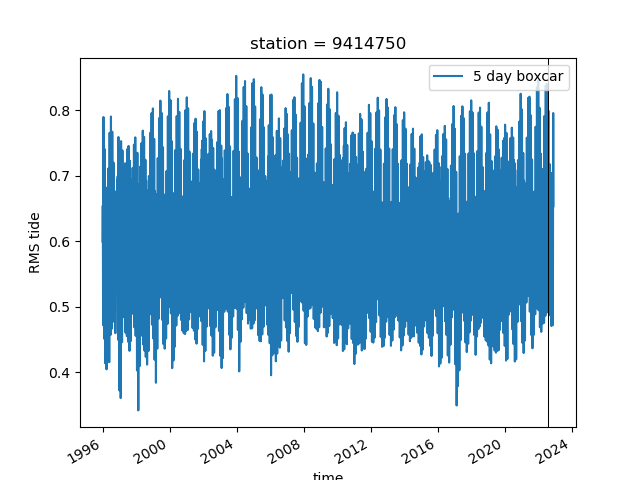

In [7]:
from stompy import filters
six.moves.reload_module(filters)
wse=alameda_regular.water_level
wse_mean= filters.lowpass_fir(wse**2,winsize=np.timedelta64(60,'h'))**0.5
        
def lp(x):
    return filters.lowpass_fir(x,winsize=np.timedelta64(60,'h'))
rms_tide=lp( (wse - lp(wse))**2 ) ** 0.5
rms_tide.name="RMS tide"                             

fig,ax=plt.subplots()

#wse.plot(label="WSE")
#rms_tide.plot(label="RMS tide")
agg_metric=filters.lowpass_fir(rms_tide,winsize=np.timedelta64(5,'D'),window='boxcar')
agg_metric.plot(label='5 day boxcar')

ax.legend(loc='upper right')
ax.axvline(bloom_start,color='k',lw=0.75)

In [21]:
# For a given metric, plot some date ranges, and compare time of bloom
# to overall distribution
window=window_of_opportunity
time_res=np.timedelta64(1,'D')

def yearly_sel(t,min_doy,max_doy):
    doy=(t - t.astype('M8[Y]'))/np.timedelta64(1,'D')
    return (doy>=min_doy)&(doy<max_doy)

periods=[ 
    dict(name='Previous month',
         label='prevmonth',
         pred=lambda t: (t>=np.datetime64("2022-07-10")) & (t<np.datetime64("2022-08-10"))),
    dict(name='Previous 2 months',
         label='prev2months',
         pred=lambda t: (t>=np.datetime64("2022-06-10")) & (t<np.datetime64("2022-08-10"))),
    dict(name='July-Aug yearly',
         label='all_july_aug',
         pred=lambda t: yearly_sel(t,181,243) # July 1 to Aug 31, +-leap day 
        ),
]


def metric_cdfs(metric_da,window=window_of_opportunity,
                time_res=np.timedelta64(1,'D'),
                bloom_start=np.datetime64("2022-08-04"),
                show_unfiltered=False,
                periods=periods):
    """
    Plot univariate distributions of the given metric, averaged over
    window-of-opportunity (boxcar), and show where the bloom period
    falls within the distributions, for multiple periods.
    
    metric_da is expected to have a meaningful name.
    show_unfiltered: also plot the metric before any averaging.
    return a list of figures corresponding to the periods.
    """
    if isinstance(metric_da,tuple):
        metric_da1,metric_da2,join = metric_da
        metric_da=join(metric_da1,metric_da2)
    else:
        metric_da1=metric_da2=None
        
    # aggregate over window of opportunity:
    metric = metric_da.values
    agg_metric = filters.lowpass_fir(metric_da,window,window='boxcar')
    agg_metric.name = metric_da.name+", 5d boxcar"
    stride=int(time_res/ np.median(np.diff(agg_metric.time)))
    agg_metric = agg_metric.isel(time=slice(None,None,stride))
    
    sample=agg_metric.sel(time=bloom_start, method='nearest')
        
    t=agg_metric.time.values
    figs=[]
    for period in periods:
        sel=period['pred'](t)
        period_metric=agg_metric.isel(time=sel)
        period_samples = period_metric.values
        period_samples=period_samples[ np.isfinite(period_samples) ]
        period_samples = np.sort(period_samples)
        rank=np.searchsorted(period_samples,sample)
        pctile=100*rank/len(period_samples)
        
        print(f"{period['name']}: {pctile:.1f} percentile")
        
        fig,axs=plt.subplots(1,2,figsize=(8,4.5))
        
        axs[0].plot(agg_metric.time, agg_metric,color='0.6',lw=0.75,label=agg_metric.name)
        axs[0].plot(agg_metric.time, np.where(sel,agg_metric.values,np.nan),label='Comparison period')
        axs[0].axvline(bloom_start,color='k',lw=0.8,label='Bloom start')
        if show_unfiltered:
            axs[0].plot(metric_da.time, metric_da, color='0.8',lw=0.5,alpha=0.5,zorder=-1,
                       label=metric_da.name)
        
        axs[1].hist( period_samples, bins=20)
        axs[1].axvline(sample,color='k',lw=0.8)
        axs[1].set_xlabel('Period metric')
        label=metric_da.name
        axs[1].set_title(f"{label}\n{pctile:.1f} percentile",fontsize=9)
        # ha='right',va='top',transform=axs[1].transAxes)

        t_range=[period_metric.time.min(),
                 period_metric.time.max()]
        pad=0.08*(t_range[1]-t_range[0])
        axs[0].axis( xmin=t_range[0]-pad,xmax=t_range[1]+pad)
        axs[0].legend(loc='lower left',bbox_to_anchor=(-0.2,1.02),frameon=0,ncol=2)
        fig.subplots_adjust(top=0.8,right=0.97,bottom=0.1)
        fig.autofmt_xdate()
        figs.append(fig)
        
    return figs
        

Previous month: 0.0 percentile


<IPython.core.display.Javascript object>


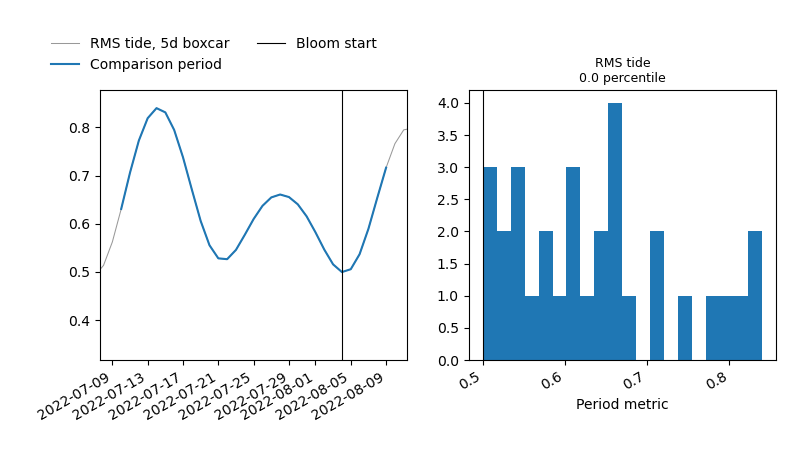

Previous 2 months: 3.3 percentile


<IPython.core.display.Javascript object>


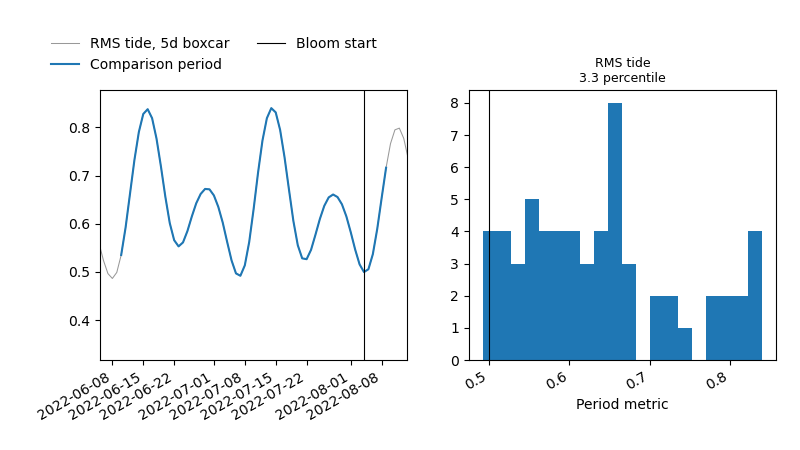

July-Aug 2020-2022: 13.7 percentile


<IPython.core.display.Javascript object>


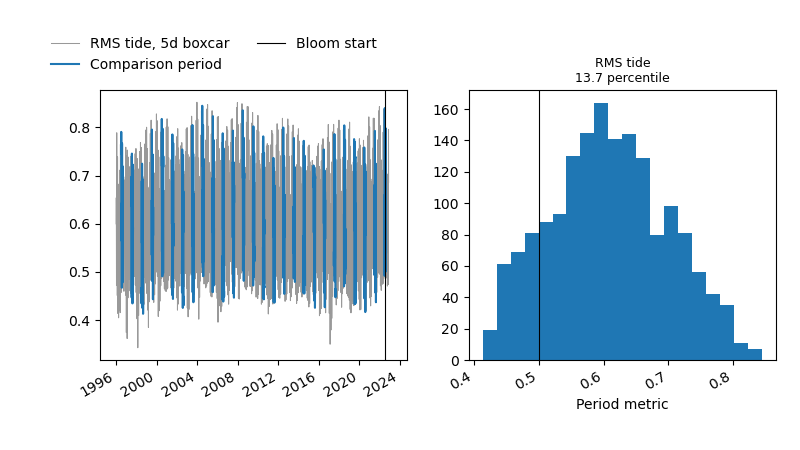

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [9]:
metric_cdfs(rms_tide)

Previous month: 9.7 percentile


<IPython.core.display.Javascript object>


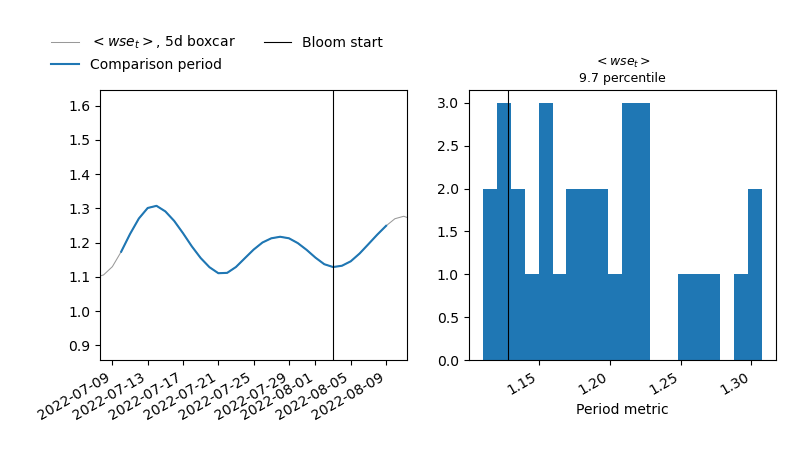

Previous 2 months: 18.0 percentile


<IPython.core.display.Javascript object>


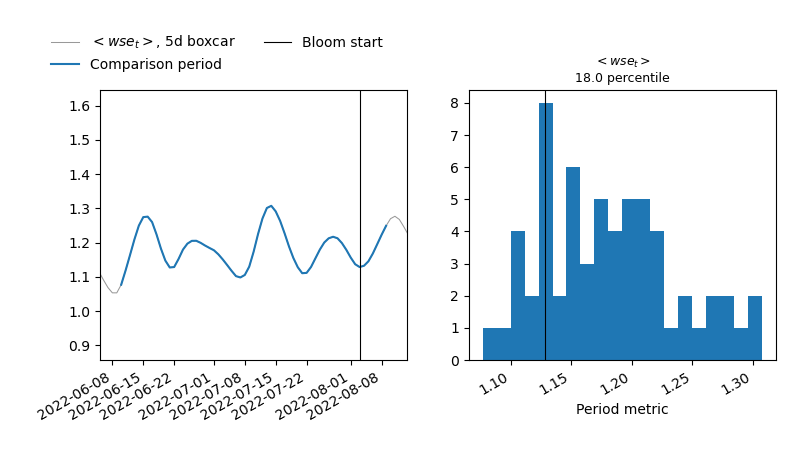

July-Aug 2020-2022: 15.0 percentile


<IPython.core.display.Javascript object>


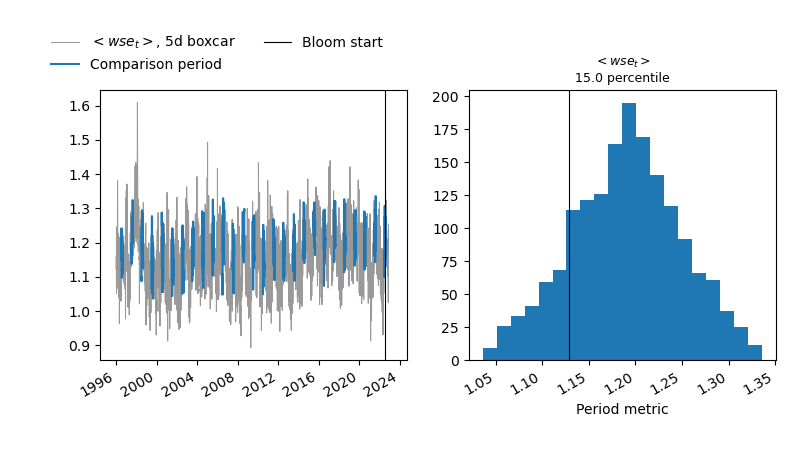

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [10]:
# Combine tides and daylight
# For this I want a measure of tidal currents.
# Could go with harmonics, but that might be too location specific.
# Not sufficient to just use water level directly since I want a 
# measure of mixing.
# Try time derivative of WSE.
# Check against distribution of d WSE/dt along the way.
wse=alameda_regular.water_level
d_wse = np.diff(wse) / (np.diff(wse.time)/np.timedelta64(3600,'s')) # velocity units

d_wse_rms= filters.lowpass_fir(wse**2,winsize=np.timedelta64(60,'h'))**0.5
d_wse_rms.name="$<wse_t>$"    

metric_cdfs(d_wse_rms,bloom_start=np.datetime64("2022-08-03"))

<IPython.core.display.Javascript object>


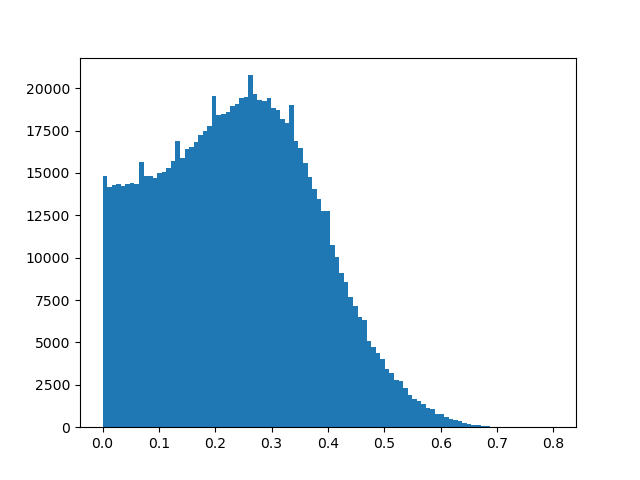

In [11]:
plt.figure()
# simple absolute value gives a reasonable distribution.
plt.hist(np.abs(d_wse),bins=np.linspace(0,0.8,100)) ;

In [12]:
wse=alameda_regular.water_level
d_wse = np.abs(np.diff(wse)) / (np.diff(wse.time)/np.timedelta64(3600,'s')) # [m/hour]

mid_time=wse.time.values[:-1] + 0.5*np.diff(wse.time.values)
sol_rad=utils.ideal_solar_rad(mid_time).sol_rad

# How to combine d_wse and sol_rad?
# (a) try something ad hoc and easy to adjust to see if a signal exists, and
# (b) plot as 2D scatter.

# 0.5 m/h is an energetic tide. Call that the max.
rad_weighted=(0.5-np.abs(d_wse)).clip(0) * sol_rad
rad_weighted.name=r"(1-$\eta_t$)rad"


<IPython.core.display.Javascript object>


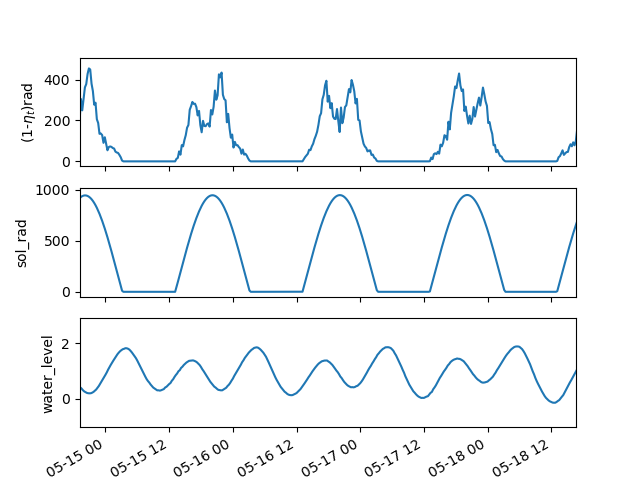

(15474.8, 15478.694, -24.157165232997606, 507.3004698929497)

In [13]:
fig,axs=plt.subplots(3,1,sharex=True)
rad_weighted.plot(ax=axs[0])
sol_rad.plot(ax=axs[1])
wse.plot(ax=axs[2])

axs[2].set_title('')
for ax in axs[:2]:
    ax.set_xlabel('')
axs[0].axis(xmin=15474.80, xmax=15478.694)

Previous month: 67.7 percentile


<IPython.core.display.Javascript object>


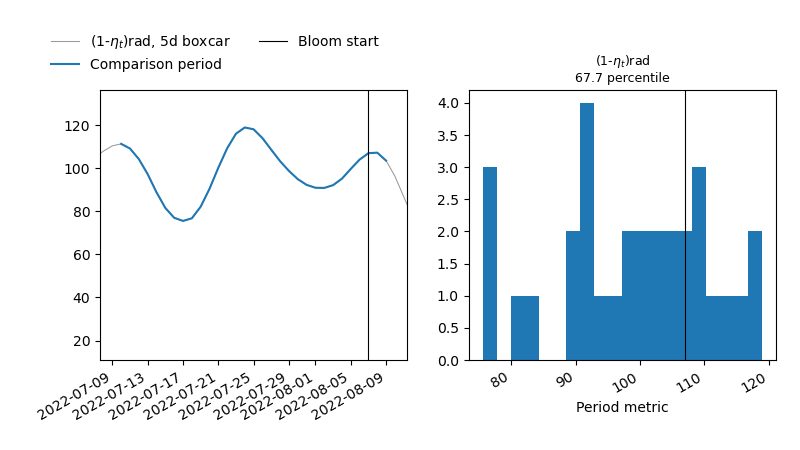

Previous 2 months: 70.5 percentile


<IPython.core.display.Javascript object>


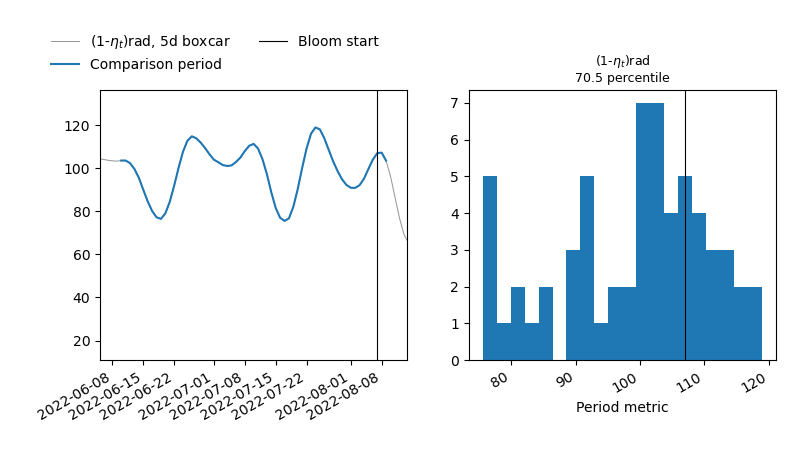

July-Aug 2020-2022: 79.2 percentile


<IPython.core.display.Javascript object>


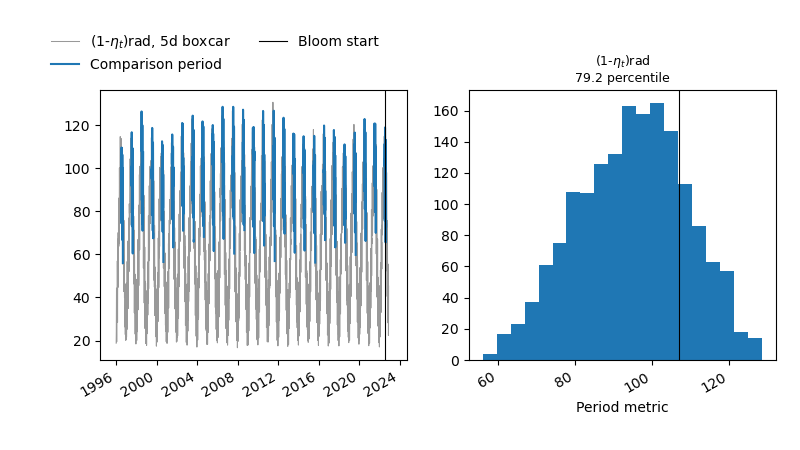

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [14]:
def join(d_wse,sol_rad):
    rad_weighted=(0.5-np.abs(d_wse)).clip(0) * sol_rad
    rad_weighted.name=r"(1-$\eta_t$)rad"
    return rad_weighted

eta_t=xr.DataArray(d_wse, dims='time',coords=[sol_rad.time],name='eta_t')
    
metric_cdfs(join(eta_t,sol_rad),
             bloom_start=np.datetime64("2022-08-07"))


In [25]:
import seaborn as sns
from scipy.ndimage import gaussian_filter

<IPython.core.display.Javascript object>


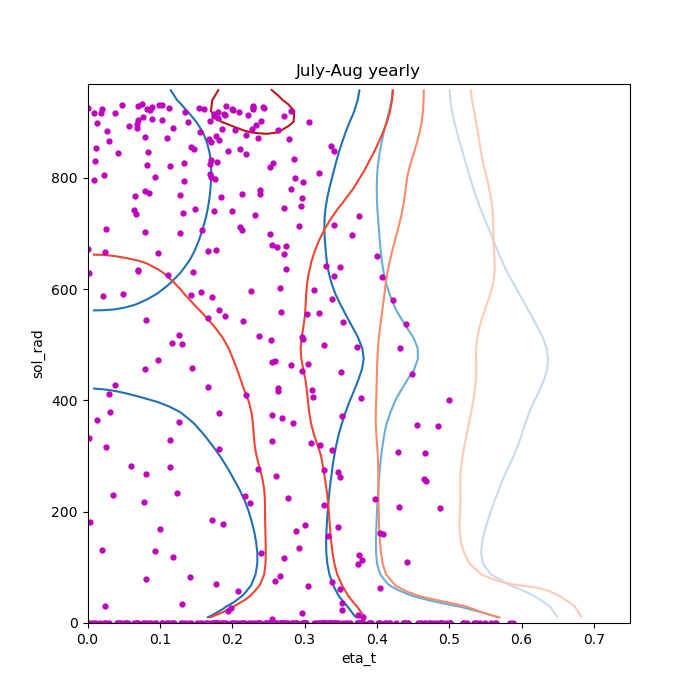

In [30]:
def rankplot(x,y,xxyy,ax,bins=50,cmap='blues', smooth=5, colors=None):
    H,xbins,ybins=np.histogram2d(x, y, bins=50, range=[xxyy[:2],xxyy[2:]])
    H+=np.random.random(H.shape)*0.5 # randomly break ties 
    # argsort^2 gives rank
    ranks=np.argsort(np.argsort(H.ravel())).reshape(H.shape)
    
    if smooth>0:
        ranks=gaussian_filter(ranks,sigma=smooth)
    
    #img=ax.imshow( ranks.T, extent=xxyy,aspect='auto',origin='lower')
    #return img
    X=0.5*(xbins[:-1] + xbins[1:])
    Y=0.5*(ybins[:-1] + ybins[1:])
    cset=ax.contour( X, Y, ranks.T, 3, cmap=cmap,colors=colors)
    return cset

def joint_pdf(metric_da1,metric_da2,join,period):
    t=metric_da1.time.values
    sel2=period['pred'](t)
    
    if 'range' in metric_da1.attrs:
        xx=metric_da1.attrs['range']
    else:
        xx=[metric_da1.values.min(), metric_da1.values.max()]
    if 'range' in metric_da2.attrs:
        yy=metric_da2.attrs['range']
    else:
        yy=[metric_da2.values.min(), metric_da2.values.max()]
    xxyy=list(xx)+list(yy)
    
    fig,ax=plt.subplots(1,1,figsize=(7,7))
    #ax.plot( metric_da1, metric_da2, 'k.',ms=2,alpha=0.2)
    #sns.histplot(x=metric_da1,y=metric_da2,zorder=-1)
    rankplot(metric_da1,metric_da2,xxyy,ax=ax,cmap='Blues',
             smooth=2)
    
    #ax.plot( metric_da1.isel(time=sel2), metric_da2.isel(time=sel2), 'b.',ms=2,alpha=0.5)
    #sns.kdeplot(x=metric_da1.isel(time=sel2).values, 
    #            y=metric_da2.isel(time=sel2).values,
    #            ax=ax,levels=5,color='blue',zorder=4)
    rankplot(metric_da1.isel(time=sel2),
             metric_da2.isel(time=sel2),
             xxyy,ax=ax,cmap='Reds',smooth=2)

    sel_sample=(t>=bloom_start - window/2) & (t<bloom_start + window - window/2)
    ax.plot( metric_da1.isel(time=sel_sample), metric_da2.isel(time=sel_sample), 
             '.',color='m',ms=7)
    ax.set_xlabel(metric_da1.name)
    ax.set_ylabel(metric_da2.name)
    ax.axis(xxyy)
    ax.set_title(period['name'])

eta_t.attrs['range']=(0,0.75)
#for period in periods:
joint_pdf(eta_t,sol_rad,join,periods[2])
    

In [286]:
# Check that synthetic and CIMIS solar radiation are consistent.
cimis=xr.open_dataset("/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2001-2016.nc")
#union_city-hourly-2022_bloom.nc

cimis=cimis.set_coords('time').swap_dims({'Date':'time'})
cimis['time']=cimis['time']+np.timedelta64(8,'h') # to UTC

<IPython.core.display.Javascript object>


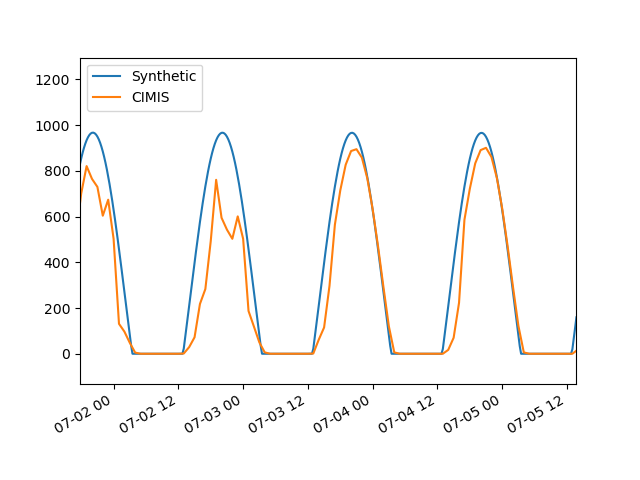

In [290]:
fig,ax=plt.subplots(1,1)
six.moves.reload_module(utils)

sol_rad=utils.ideal_solar_rad(cimis.time)
ax.plot(t,I0,label='Synthetic')
ax.plot(cimis.time, cimis.HlySolRad,label='CIMIS')
ax.legend(loc='upper left')
fig.autofmt_xdate()

In [ ]:
# Now also include Alameda wind

Previous month: 0.0 percentile


<IPython.core.display.Javascript object>


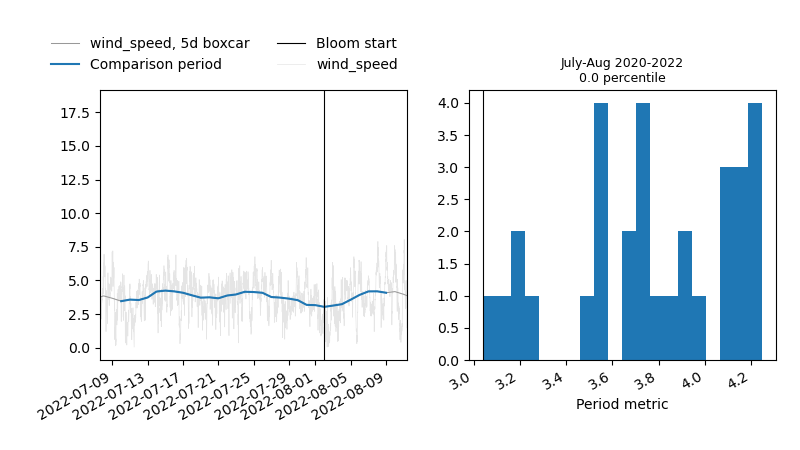

Previous 2 months: 16.4 percentile


<IPython.core.display.Javascript object>


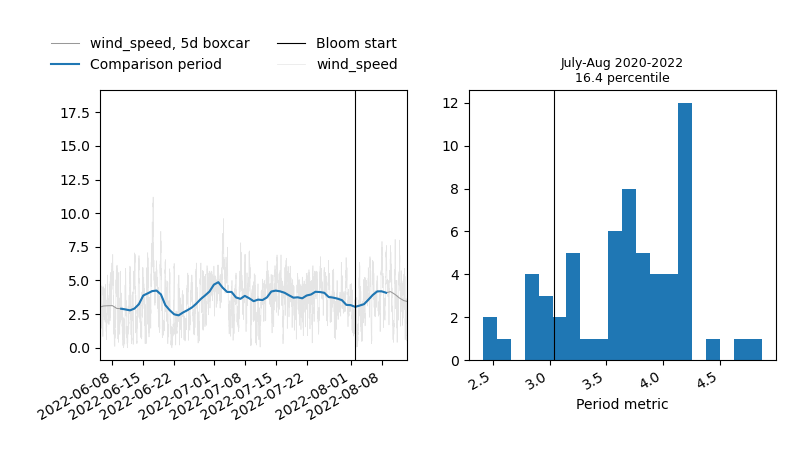

July-Aug 2020-2022: 67.6 percentile


<IPython.core.display.Javascript object>


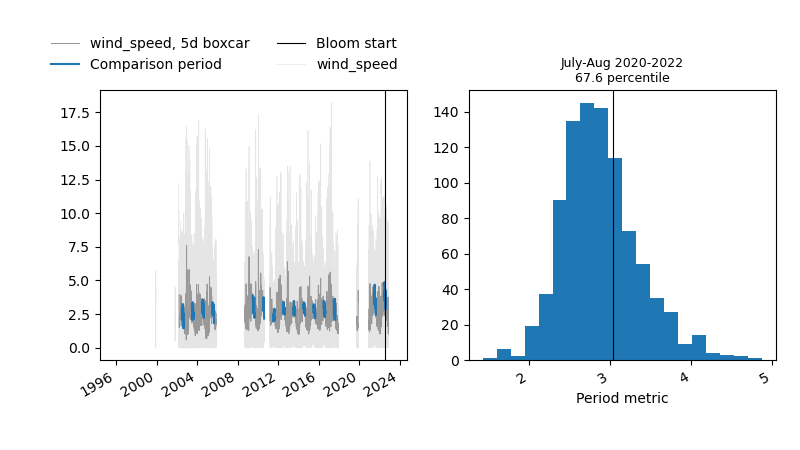

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [305]:
wind_speed=alameda_regular.wind_speed

metric_cdfs(wind_speed,bloom_start=np.datetime64("2022-08-02"),
           show_unfiltered=True)

Previous month: 96.8 percentile


<IPython.core.display.Javascript object>


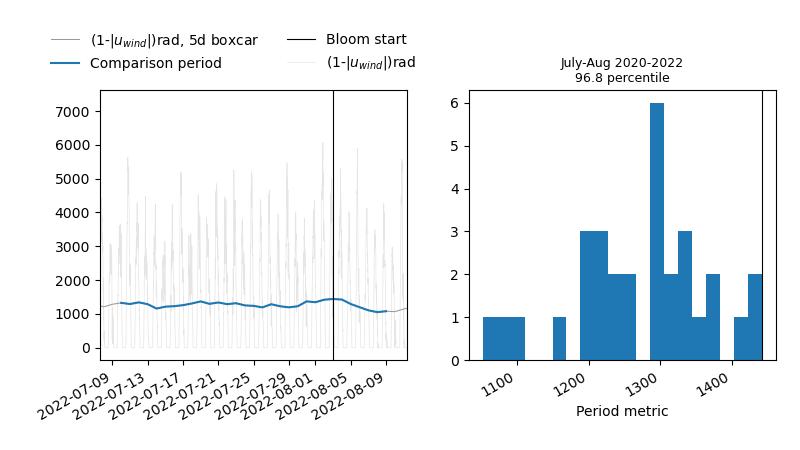

Previous 2 months: 82.0 percentile


<IPython.core.display.Javascript object>


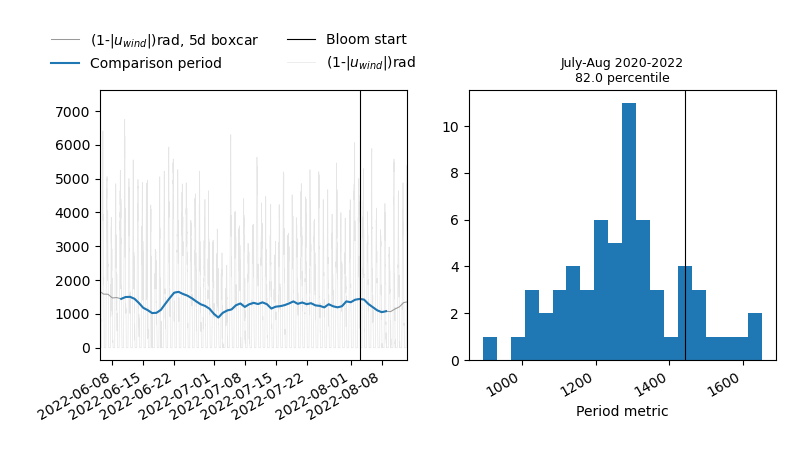

July-Aug 2020-2022: 41.4 percentile


<IPython.core.display.Javascript object>


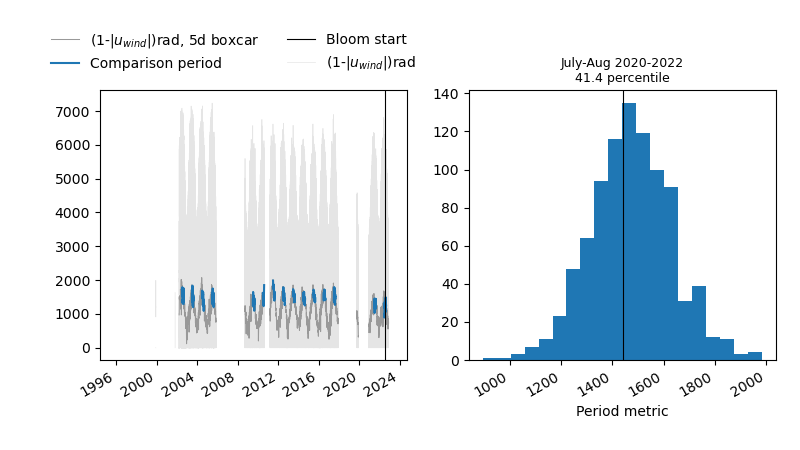

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [307]:
sol_rad=utils.ideal_solar_rad(wind_speed.time).sol_rad

# How to combine d_wse and sol_rad?
# (a) try something ad hoc and easy to adjust to see if a signal exists, and
# (b) plot as 2D scatter.

# 7.5 m/s is a decent wind. Call that the max.
wind_rad_weighted=(7.5-np.abs(wind_speed)).clip(0) * sol_rad
wind_rad_weighted.name=r"(1-$|u_{wind}|$)rad"

metric_cdfs(wind_rad_weighted,bloom_start=np.datetime64("2022-08-03"),
           show_unfiltered=True)

Using Actual Solar Radiation
--

In [319]:
# the existing data:
# Check that synthetic and CIMIS solar radiation are consistent.
cimisA=xr.open_dataset("/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2001-2016.nc")
#union_city-hourly-2022_bloom.nc

cimisA=cimisA.set_coords('time').swap_dims({'Date':'time'})
cimisA['time']=cimisA['time']+np.timedelta64(8,'h') # to UTC

In [311]:
from stompy.io.local import cimis

In [316]:
CIMIS_KEY="2cbd0eea-39b0-4e5d-9f05-f9bf1fd2e90d"

In [ ]:
cimisB=cimis.cimis_fetch_to_xr(stations=[171],
                               start_date=np.datetime64("2019-01-01"),
                               end_date = np.datetime64("2022-10-01"),
                               cache_dir='cache',
                               cimis_key=CIMIS_KEY)

cimisB['time']=cimisB['time']+np.timedelta64(8,'h') # to UTC

if 0:
    # plot, check overlap, make sure we're okay w.r.t. time zone.
    # All good.
    fig,ax=plt.subplots()
    cimisA['HlySolRad'].plot(ax=ax)
    cimisB['HlySolRad'].plot(ax=ax,alpha=0.6)

In [366]:
cimisBslice=cimisB.isel( time=cimisB.time.values>cimisA.time.values[-1])
cimis = xr.concat([cimisA.drop('Date'),cimisBslice],dim='time')

bad = cimis.HlySolRad.values<0
cimis.HlySolRad.values[bad]=np.nan

<IPython.core.display.Javascript object>


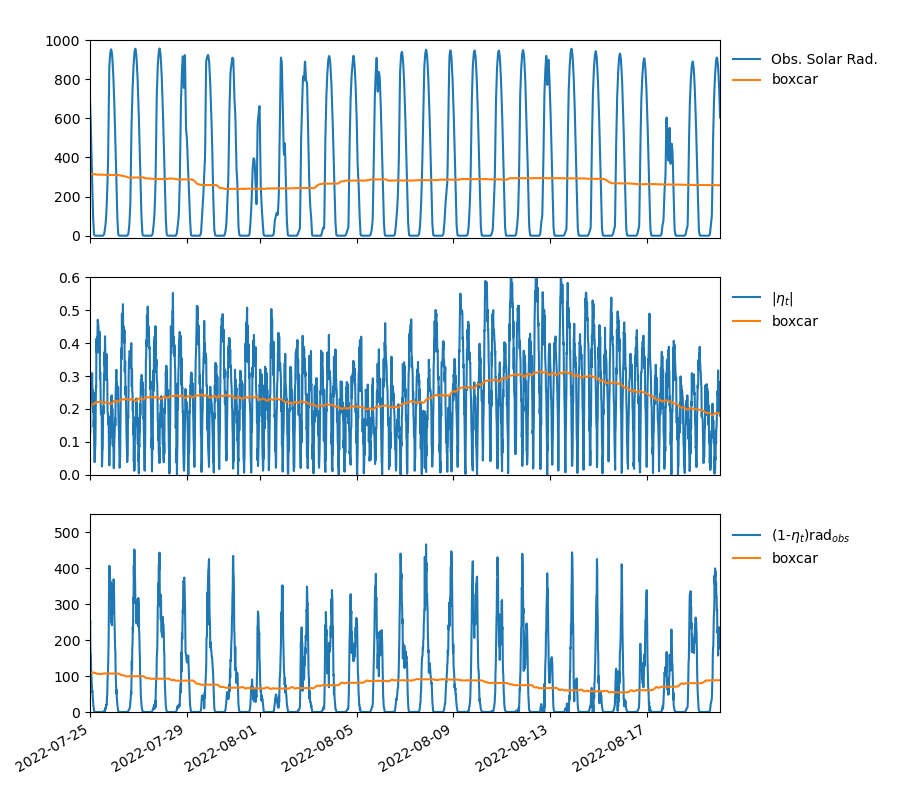

In [367]:
# add new version of calcs using this radiation field.

mid_time=wse.time.values[:-1] + 0.5*np.diff(wse.time.values)

d_wse_dnum=utils.to_dnum(mid_time)

cimis_rad=utils.interp_near(mid_time,
                            cimis.time.values, cimis.HlySolRad.values,
                            max_dx=np.timedelta64(2,'h'))


# 0.5 m/h is an energetic tide. Call that the max.
ds=xr.Dataset()
ds['time']=('time',),mid_time
ds['obs_rad']=('time',),cimis_rad
ds['d_wse']=('time',),np.abs(d_wse)
ds['cimis_weighted']=(0.5-ds.d_wse).clip(0) * ds.obs_rad
obs_rad_weighted=ds.cimis_weighted
obs_rad_weighted.name=r"(1-$\eta_t$)rad$_{obs}$"

fig,axs=plt.subplots(3,1,sharex=True,figsize=(9,8))

def boxcar(da):
    return filters.lowpass_fir(da,window_of_opportunity,window='boxcar')

axs[0].plot(ds.time, ds.obs_rad,label='Obs. Solar Rad.')
agg_rad=boxcar(ds.obs_rad)
axs[0].plot(agg_rad.time, agg_rad,label='boxcar')
axs[1].plot(ds.time, ds.d_wse, label='|$\eta_t|$')
agg_d_wse=boxcar(ds.d_wse)
axs[1].plot(agg_d_wse.time,agg_d_wse,label='boxcar')

axs[2].plot(obs_rad_weighted.time, obs_rad_weighted, label=obs_rad_weighted.name)
agg_metric = boxcar(obs_rad_weighted)
axs[2].plot( agg_metric.time, agg_metric, label='boxcar')
lkw=dict(loc='upper left',bbox_to_anchor=[1,1],frameon=0)
[ax.legend(**lkw) for ax in axs]

axs[0].axis( xmin=np.datetime64("2022-07-25"),
             xmax=np.datetime64("2022-08-20") )
axs[0].axis(ymin=-10,ymax=1000)
axs[1].axis(ymin=0.0,ymax=0.6)
axs[2].axis(ymin=0.0)

fig.autofmt_xdate()
fig.subplots_adjust(top=0.95,right=0.8,left=0.1,bottom=0.11)

Previous month: 58.1 percentile


<IPython.core.display.Javascript object>


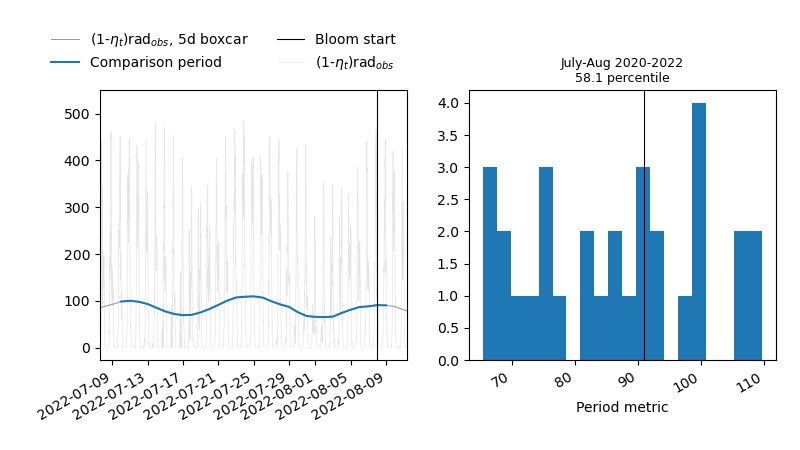

Previous 2 months: 63.9 percentile


<IPython.core.display.Javascript object>


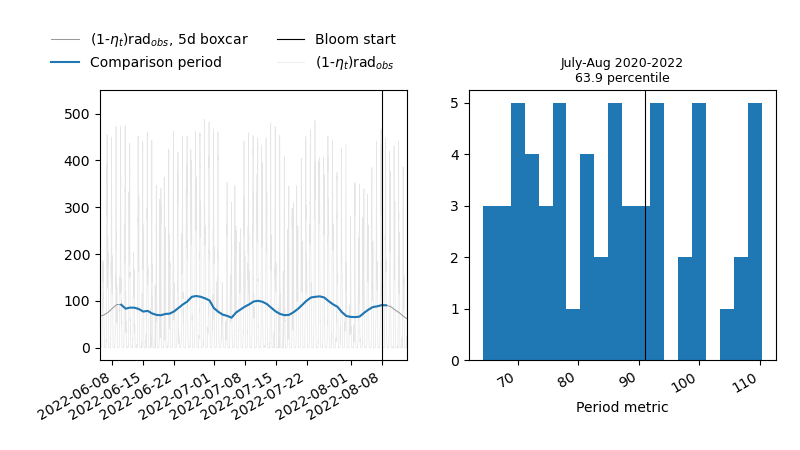

July-Aug 2020-2022: 76.1 percentile


<IPython.core.display.Javascript object>


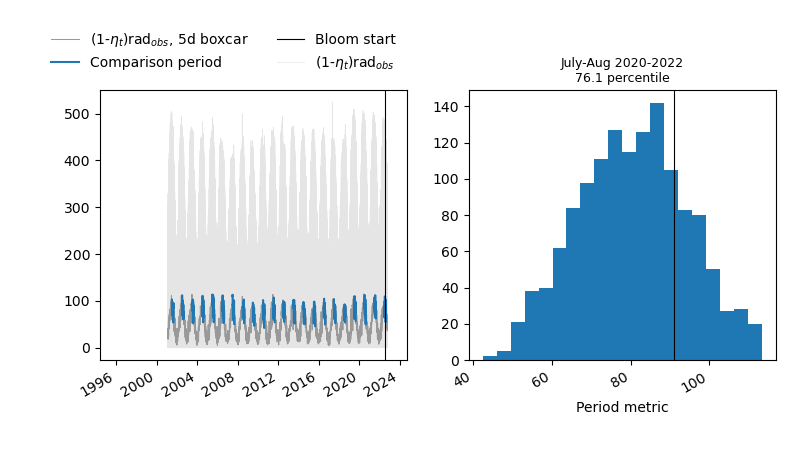

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [368]:
metric_cdfs(obs_rad_weighted,bloom_start=np.datetime64("2022-08-08"),
            show_unfiltered=True)

Turbidity
--

In [369]:
# Similar but with SSC.
from stompy.io.local import usgs_nwis
alcatraz_id=374938122251801

alcatraz=usgs_nwis.nwis_dataset(alcatraz_id,
                                start_date=np.datetime64("2010-10-01"),
                                end_date=np.datetime64("2022-10-01"),
                                products=[63680], # Turbidity, FNU.
                                cache_dir='cache')


<IPython.core.display.Javascript object>


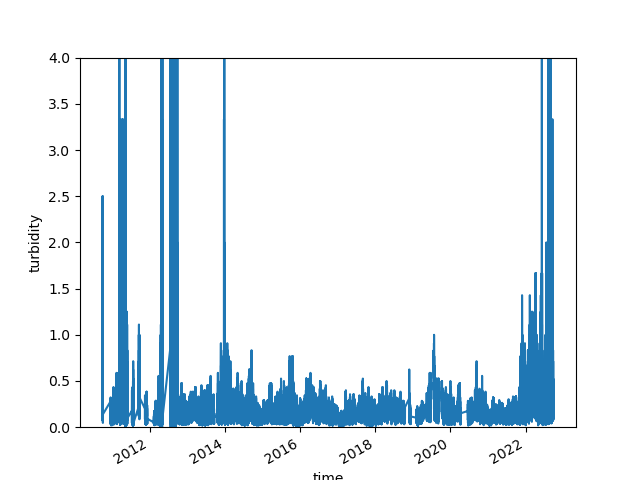

(14663.964583333334, 19482.743749999998, 0.0, 4.0)

In [383]:
fig,ax=plt.subplots()
(1./alcatraz['turbidity']).plot()
ax.axis(ymin=0,ymax=4)

Previous month: 0.0 percentile


<IPython.core.display.Javascript object>


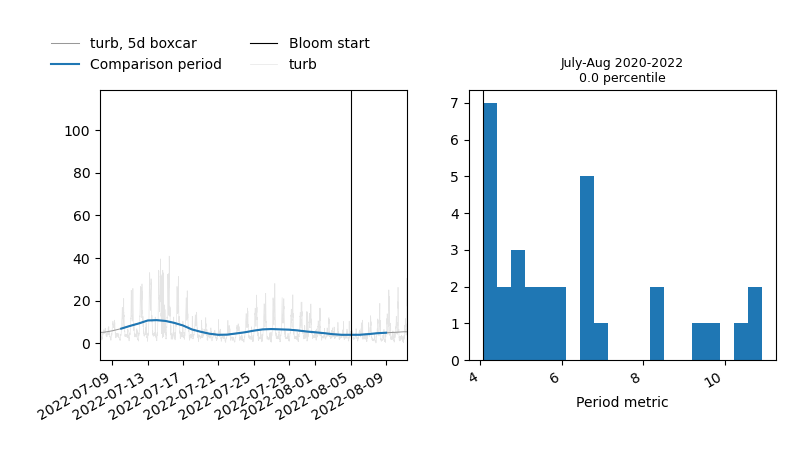

Previous 2 months: 3.8 percentile


<IPython.core.display.Javascript object>


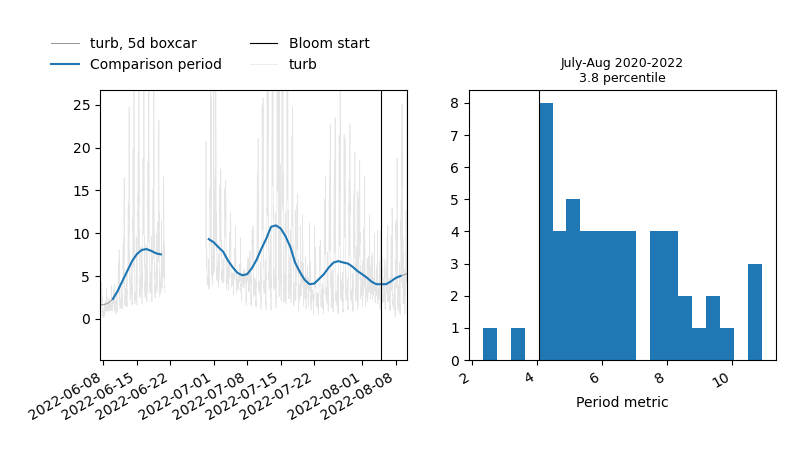

July-Aug 2020-2022: 9.8 percentile


<IPython.core.display.Javascript object>


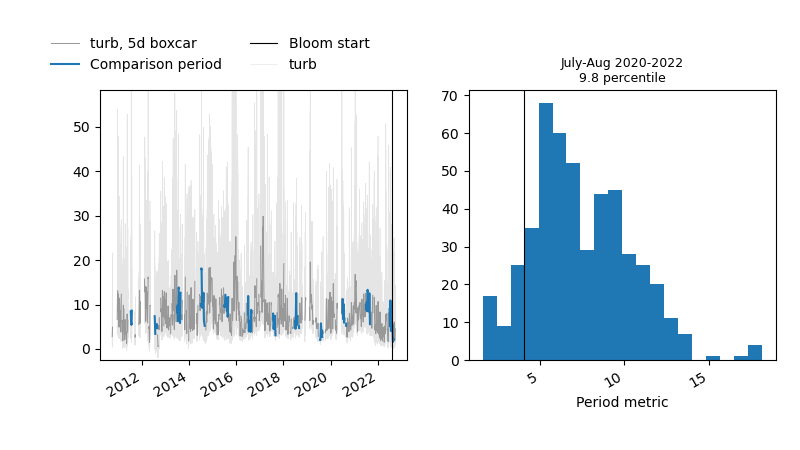

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [380]:
# Get turbidity onto the rms_tide timeline
turb_orig=alcatraz['turbidity']
turb=utils.interp_near(rms_tide.time,
                       turb_orig.time.values, turb_orig.values,
                       max_dx=np.timedelta64(2,'h'))
ds=xr.Dataset()
ds['time']=rms_tide.time
ds['turb']=('time',),turb

metric_cdfs(ds['turb'],
            bloom_start=np.datetime64("2022-08-05"),
            show_unfiltered=True)

Previous month: 3.2 percentile


<IPython.core.display.Javascript object>


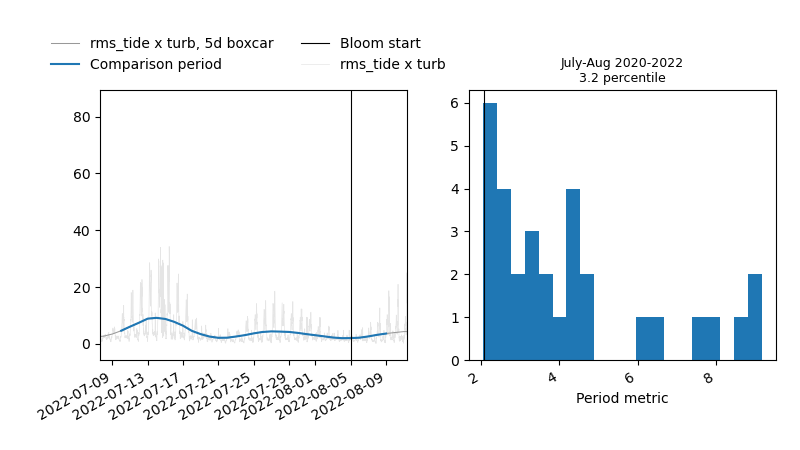

Previous 2 months: 3.8 percentile


<IPython.core.display.Javascript object>


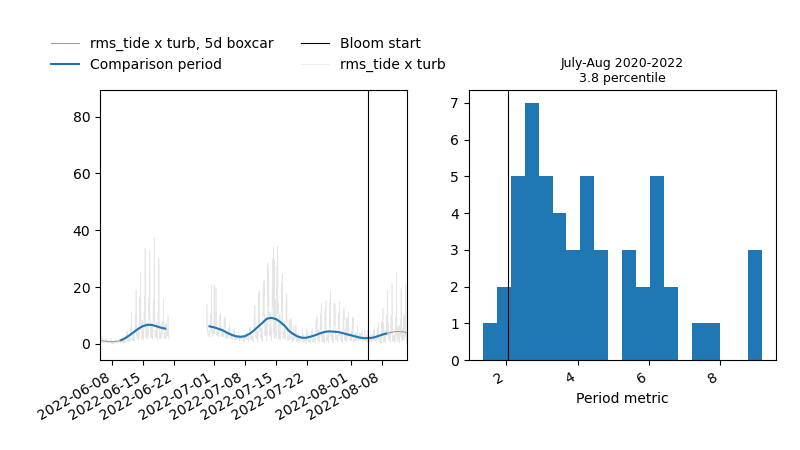

July-Aug 2020-2022: 8.5 percentile


<IPython.core.display.Javascript object>


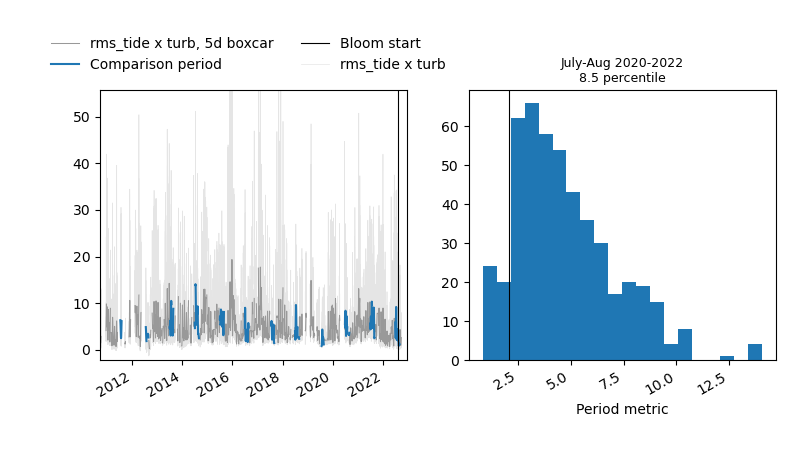

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [381]:
# Combine spring-neap and turbidity

ds=xr.Dataset()
ds['time']=rms_tide.time
ds['turb']=('time',),turb
ds['rms_tide']=rms_tide
ds['combined']=ds.turb * ds.rms_tide

da=ds.combined
da.name="rms_tide x turb"
metric_cdfs(da,
            bloom_start=np.datetime64("2022-08-05"),
            show_unfiltered=True)

In [31]:
alameda_regular

<xarray.Dataset>
Dimensions:            (time: 943776)
Coordinates:
  * time               (time) datetime64[ns] 1996-01-01 ... 2022-11-30T23:45:00
    station            <U7 '9414750'
Data variables:
    name               object 'Alameda'
    lat                float64 37.77
    lon                float64 -122.3
    water_level        (time) float64 0.08133 0.1215 0.172 ... 1.368 1.426 1.48
    wind_speed         (time) float64 nan nan nan nan nan ... nan nan nan nan
    wind_direction     (time) float64 nan nan nan nan nan ... nan nan nan nan
    wind_gust          (time) float64 nan nan nan nan nan ... nan nan nan nan
    water_temperature  (time) float64 12.7 nan nan nan 12.7 ... nan nan nan nan
    air_temperature    (time) float64 nan nan nan nan nan ... nan nan nan nan

Previous month: 74.2 percentile


<IPython.core.display.Javascript object>


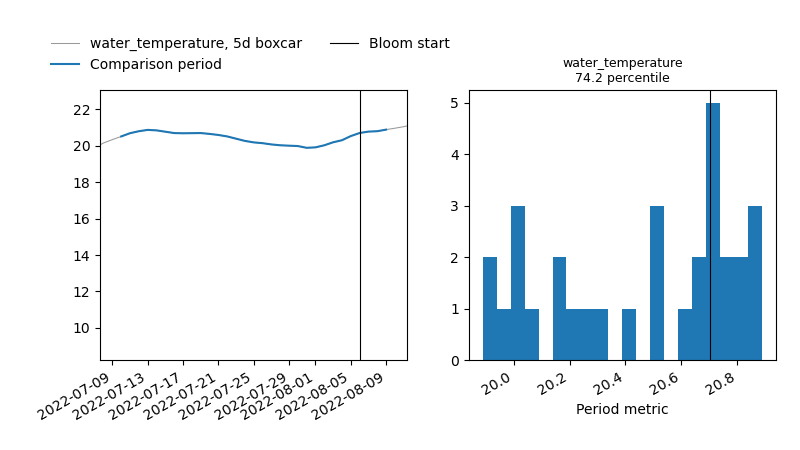

Previous 2 months: 65.6 percentile


<IPython.core.display.Javascript object>


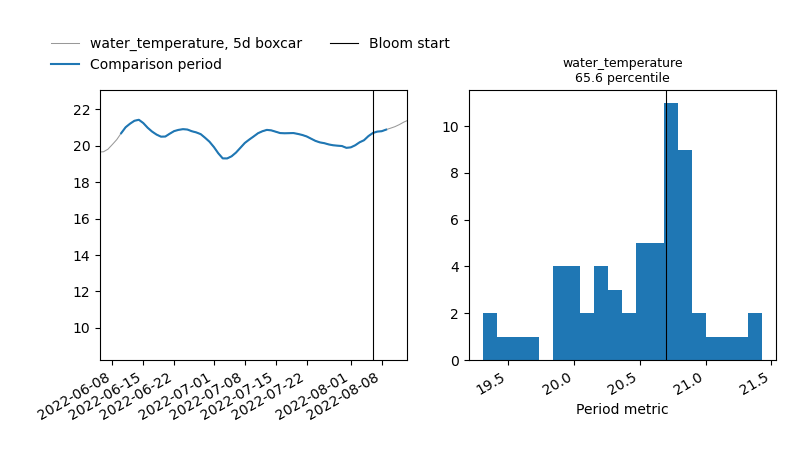

July-Aug yearly: 71.9 percentile


<IPython.core.display.Javascript object>


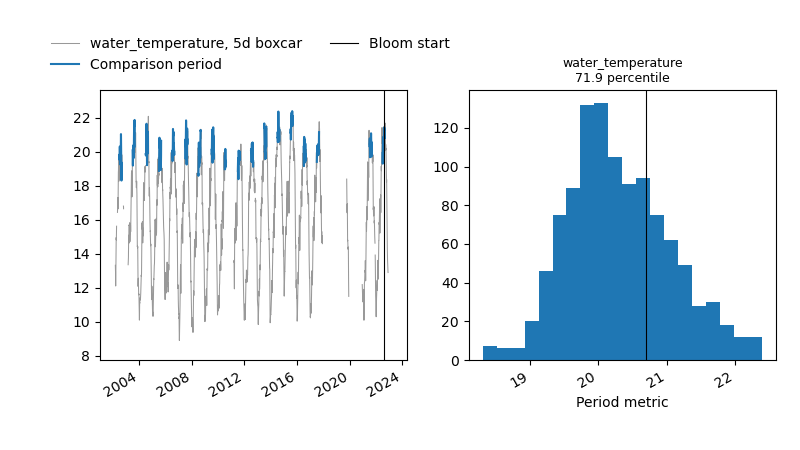

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [33]:
# Temperature
metric_cdfs(alameda_regular['water_temperature'],
            bloom_start=np.datetime64("2022-08-06"))

Previous month: 87.1 percentile


<IPython.core.display.Javascript object>


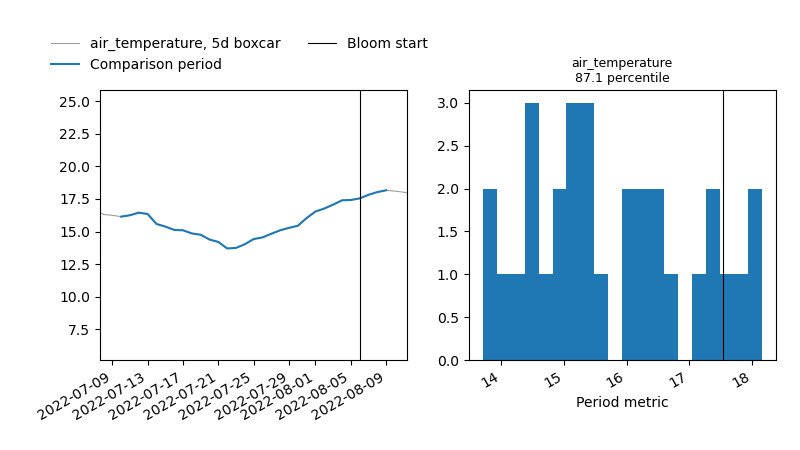

Previous 2 months: 80.3 percentile


<IPython.core.display.Javascript object>


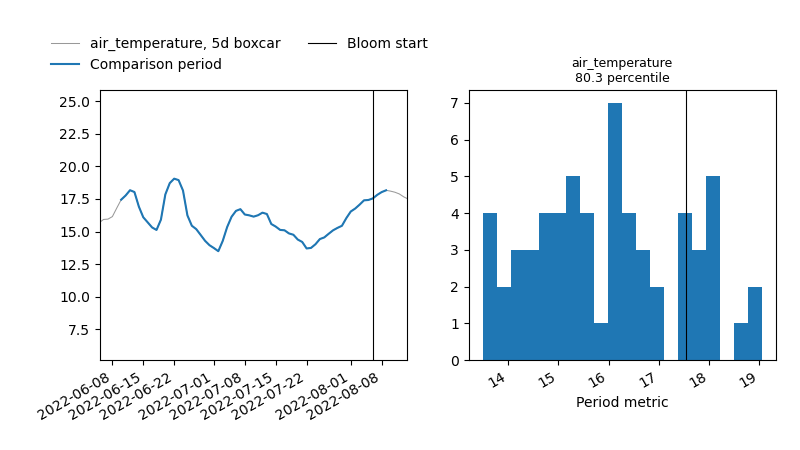

July-Aug yearly: 82.6 percentile


<IPython.core.display.Javascript object>


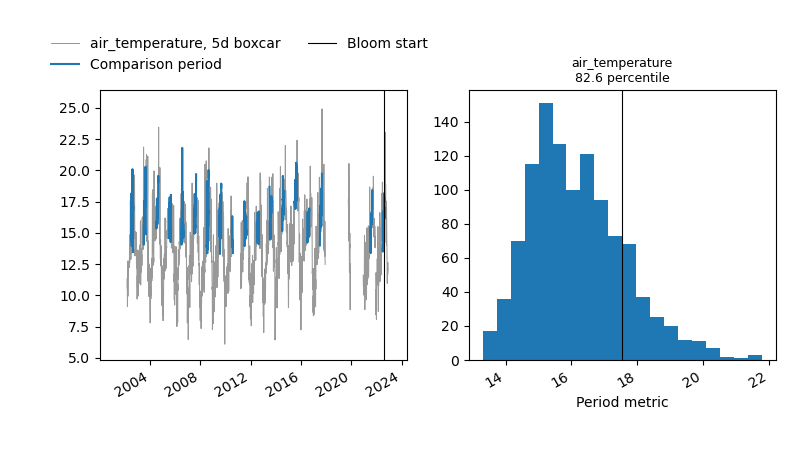

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [34]:
# Temperature
metric_cdfs(alameda_regular['air_temperature'],
            bloom_start=np.datetime64("2022-08-06"))

Previous month: 96.8 percentile


<IPython.core.display.Javascript object>


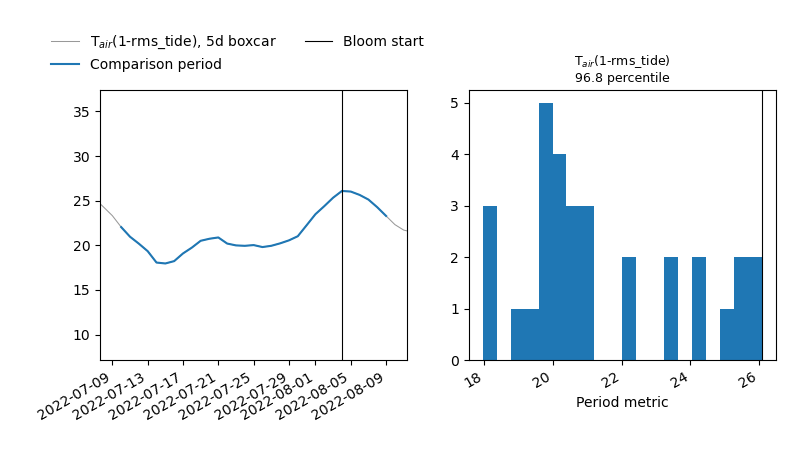

Previous 2 months: 91.8 percentile


/tmp/ipykernel_3965348/4089870927.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs=plt.subplots(1,2,figsize=(8,4.5))


<IPython.core.display.Javascript object>


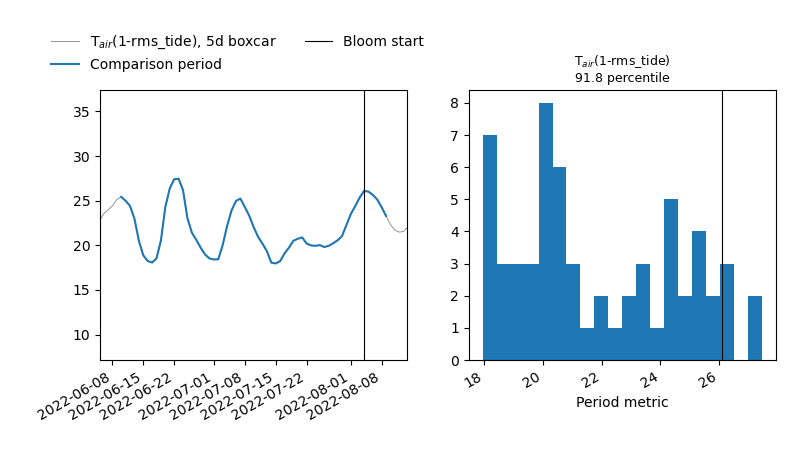

July-Aug yearly: 90.6 percentile


<IPython.core.display.Javascript object>


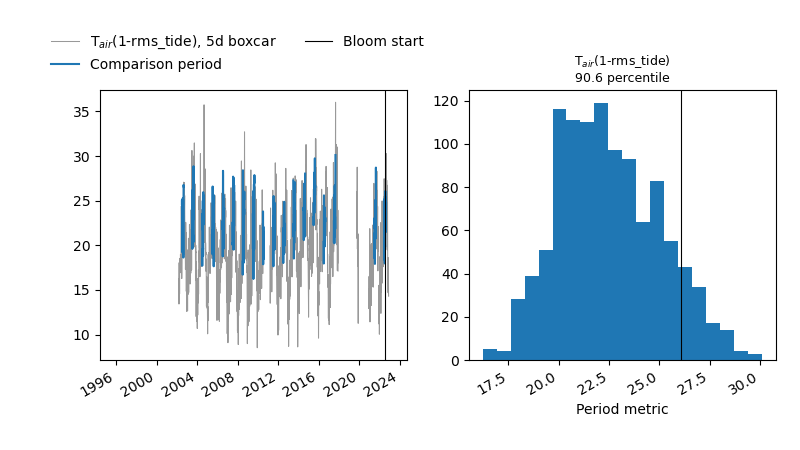

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [38]:
# Air temperature and spring/neap
tide_and_temp=alameda_regular['air_temperature']*(2-rms_tide).clip(0)
tide_and_temp.name="T$_{air}$(1-rms_tide)"
metric_cdfs(tide_and_temp,
            bloom_start=np.datetime64("2022-08-04"))

Previous month: 93.5 percentile


<IPython.core.display.Javascript object>


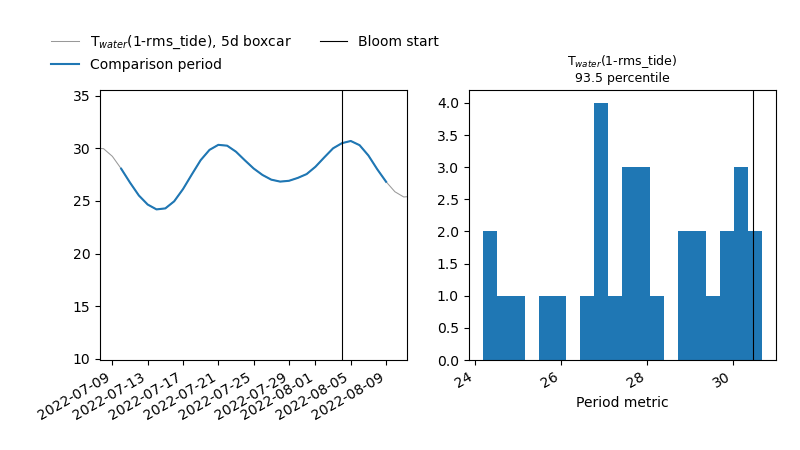

Previous 2 months: 96.7 percentile


<IPython.core.display.Javascript object>


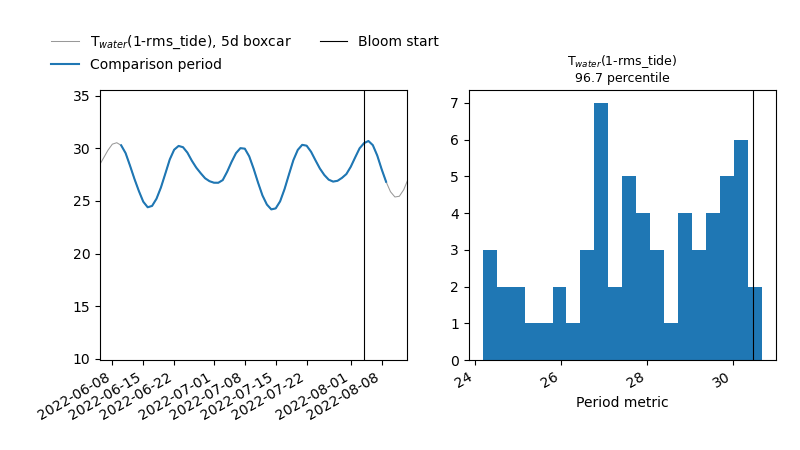

July-Aug yearly: 83.2 percentile


<IPython.core.display.Javascript object>


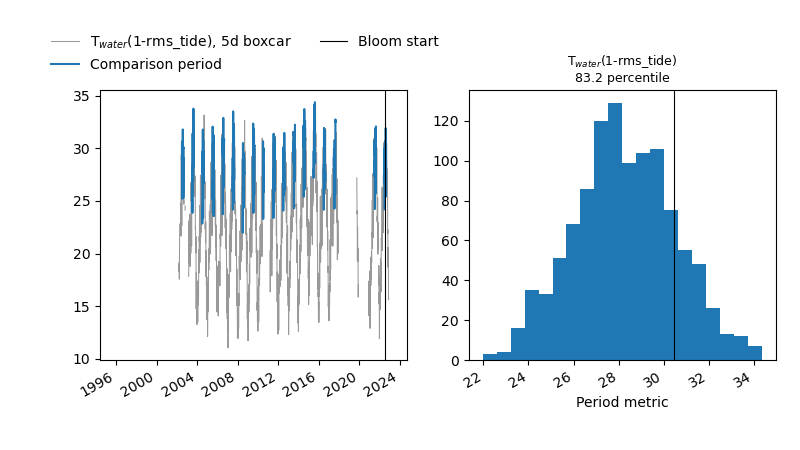

[<Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>,
 <Figure size 800x450 with 2 Axes>]

In [39]:
# Water temperature and spring/neap
tide_and_temp=alameda_regular['water_temperature']*(2-rms_tide).clip(0)
tide_and_temp.name="T$_{water}$(1-rms_tide)"
metric_cdfs(tide_and_temp,
            bloom_start=np.datetime64("2022-08-04"))